In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import os

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


Libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.2.2


In [ ]:
from google.colab import files

print("Select your dataset file (e.g. final_dataset.csv)")
uploaded = files.upload()

if len(uploaded) == 0:
    raise SystemExit("No file uploaded. Please upload a CSV.")

filename = next(iter(uploaded.keys()))
print("Uploaded file:", filename)

df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("Loaded dataframe shape:", df.shape)

df.head()


Select your dataset file (e.g. final_dataset.csv)


Saving final_dataset.csv to final_dataset.csv
Uploaded file: final_dataset.csv
Loaded dataframe shape: (1461, 12)


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149


In [ ]:
pd.set_option('display.max_columns', None)

print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

display(df.describe().T)

df.head(10)


Columns: ['Date', 'Month', 'Year', 'Holidays_Count', 'Days', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone', 'AQI']

Data types:
 Date                int64
Month               int64
Year                int64
Holidays_Count      int64
Days                int64
PM2.5             float64
PM10              float64
NO2               float64
SO2               float64
CO                float64
Ozone             float64
AQI                 int64
dtype: object

Missing values per column:
 Date              0
Month             0
Year              0
Holidays_Count    0
Days              0
PM2.5             0
PM10              0
NO2               0
SO2               0
CO                0
Ozone             0
AQI               0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Date,1461.0,15.729637,8.803105,1.00,8.00,16.00,23.00,31.00
Month,1461.0,6.522930,3.449884,1.00,4.00,7.00,10.00,12.00
Year,1461.0,2022.501027,1.118723,2021.00,2022.00,2023.00,2024.00,2024.00
Holidays_Count,1461.0,0.189596,0.392116,0.00,0.00,0.00,0.00,1.00
Days,1461.0,4.000684,2.001883,1.00,2.00,4.00,6.00,7.00
PM2.5,1461.0,90.774538,71.650579,0.05,41.28,72.06,118.50,1000.00
PM10,1461.0,218.219261,129.297734,9.69,115.11,199.80,297.75,1000.00
NO2,1461.0,37.184921,35.225327,2.16,17.28,30.49,45.01,433.98
SO2,1461.0,20.104921,16.543659,1.21,7.71,15.43,26.62,113.40
CO,1461.0,1.025832,0.608305,0.27,0.61,0.85,1.24,4.70


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149
5,6,1,2021,0,3,155.59,180.14,142.71,10.29,1.18,44.47,252
6,7,1,2021,0,4,118.39,131.18,98.87,9.81,0.73,48.60,288
7,8,1,2021,0,5,140.05,184.29,102.61,10.34,0.79,43.06,248
8,9,1,2021,0,6,144.01,192.43,108.43,10.41,0.85,42.23,326
9,10,1,2021,1,7,131.57,180.38,93.31,9.92,0.69,51.96,284


In [ ]:
target_col = 'AQI'

initial_rows = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")

missing = df.isnull().sum()
print("\nMissing values after cleaning:\n", missing)

X = df.drop(columns=[target_col])
y = df[target_col]

print("\nFinal feature shape:", X.shape)
print("Target shape:", y.shape)

X.head()


Removed 0 duplicate rows.

Missing values after cleaning:
 Date              0
Month             0
Year              0
Holidays_Count    0
Days              0
PM2.5             0
PM10              0
NO2               0
SO2               0
CO                0
Ozone             0
AQI               0
dtype: int64

Final feature shape: (1461, 11)
Target shape: (1461,)


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88


In [ ]:
from datetime import datetime

try:
    df['day_of_year'] = df.apply(
        lambda r: datetime(int(r['Year']), int(r['Month']), int(r['Date'])).timetuple().tm_yday,
        axis=1
    )
    print("Created feature: day_of_year")
except Exception as e:
    print("Could not create day_of_year:", e)

X = df.drop(columns=['AQI'])
y = df['AQI']

print("\nNew feature set shape:", X.shape)
X.head()


Created feature: day_of_year

New feature set shape: (1461, 12)


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,day_of_year
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,1
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,2
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,3
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,4
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,5


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaling complete.")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


Train shape: (1168, 12)
Test shape: (293, 12)

Scaling complete.
X_train_scaled shape: (1168, 12)
X_test_scaled shape: (293, 12)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def regression_metrics(y_true, y_pred):
    """Returns MAE, MSE, RMSE, R2 as a dictionary."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

def plot_true_vs_pred(y_true, y_pred, title="True vs Predicted"):
    plt.figure(figsize=(7,5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residuals_hist(y_true, y_pred, title="Residuals"):
    residuals = y_true - y_pred
    plt.figure(figsize=(7,4))
    plt.hist(residuals, bins=30, alpha=0.8)
    plt.title(title)
    plt.xlabel("Residual Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

print("Metric and plotting functions ready.")


Metric and plotting functions ready.


Decision Tree Regression Metrics:
MAE: 28.419795221843003
MSE: 1857.3754266211604
RMSE: 43.09727864519012
R2: 0.8568675026726627

Feature Importances:
PM10              0.753616
PM2.5             0.181044
Ozone             0.012927
NO2               0.012374
day_of_year       0.009615
Date              0.008064
Year              0.006589
CO                0.004512
SO2               0.004117
Days              0.003709
Month             0.003101
Holidays_Count    0.000333
dtype: float64


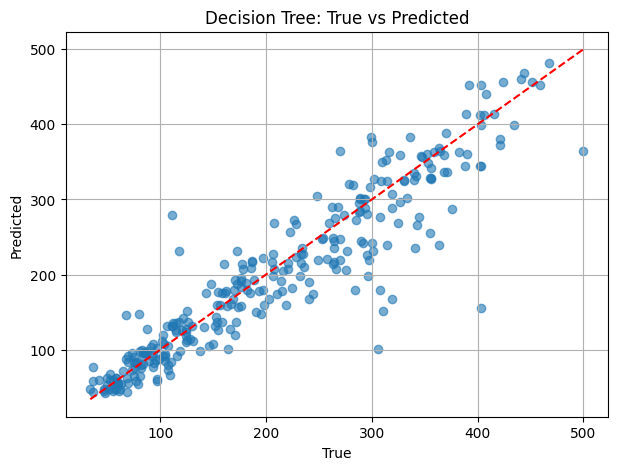

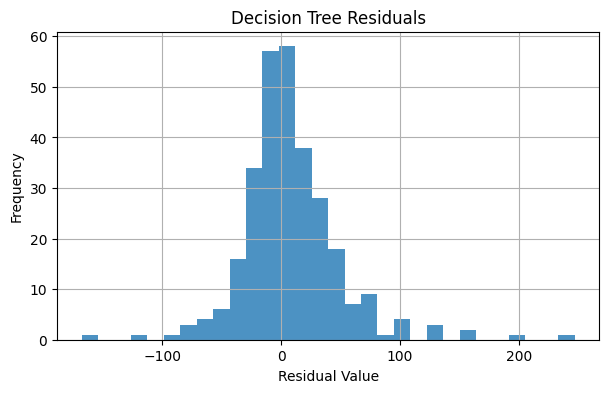

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)

y_pred_dt = dt.predict(X_test_scaled)

metrics_dt = regression_metrics(y_test, y_pred_dt)
print("Decision Tree Regression Metrics:")
for k, v in metrics_dt.items():
    print(f"{k}: {v}")

importances = pd.Series(dt.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print("\nFeature Importances:")
print(importances)

plot_true_vs_pred(y_test, y_pred_dt, title="Decision Tree: True vs Predicted")
plot_residuals_hist(y_test, y_pred_dt, title="Decision Tree Residuals")


KNN Baseline Metrics:
MAE: 30.102389078498295
MSE: 1427.4935153583617
RMSE: 37.78218515859507
R2: 0.8899949311036641

Best KNN Parameters: {'n_neighbors': 11, 'weights': 'distance'}

Tuned KNN Metrics:
MAE: 30.874550495649974
MSE: 1491.8375602783187
RMSE: 38.624313071928135
R2: 0.8850364699839918


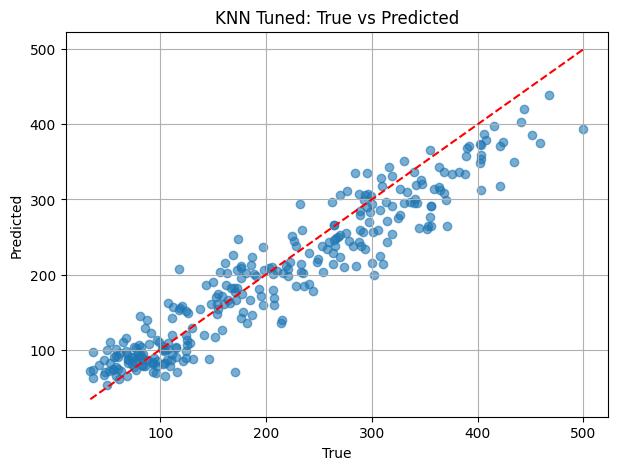

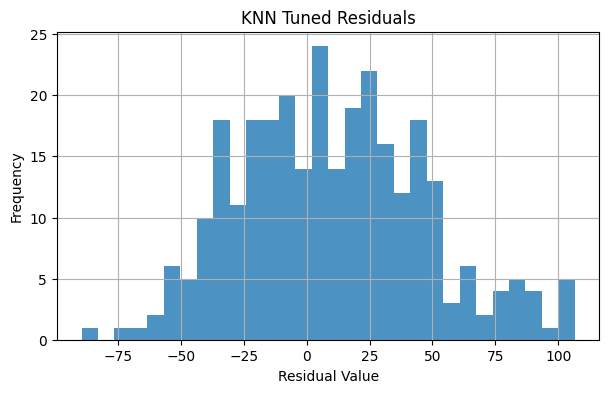

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
metrics_knn = regression_metrics(y_test, y_pred_knn)

print("KNN Baseline Metrics:")
for k, v in metrics_knn.items():
    print(f"{k}: {v}")

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train)

print("\nBest KNN Parameters:", grid_knn.best_params_)

best_knn = grid_knn.best_estimator_
y_pred_knn_best = best_knn.predict(X_test_scaled)

metrics_knn_best = regression_metrics(y_test, y_pred_knn_best)
print("\nTuned KNN Metrics:")
for k, v in metrics_knn_best.items():
    print(f"{k}: {v}")

plot_true_vs_pred(y_test, y_pred_knn_best, title="KNN Tuned: True vs Predicted")
plot_residuals_hist(y_test, y_pred_knn_best, title="KNN Tuned Residuals")


Number of components to retain 95% variance: 9
PCA-transformed shapes: (1168, 9) (293, 9)

Best PCA+KNN Parameters: {'n_neighbors': 5, 'weights': 'distance'}

PCA + KNN Metrics:
MAE: 30.144318674058933
MSE: 1449.4399019122882
RMSE: 38.07151037077841
R2: 0.8883037053720472


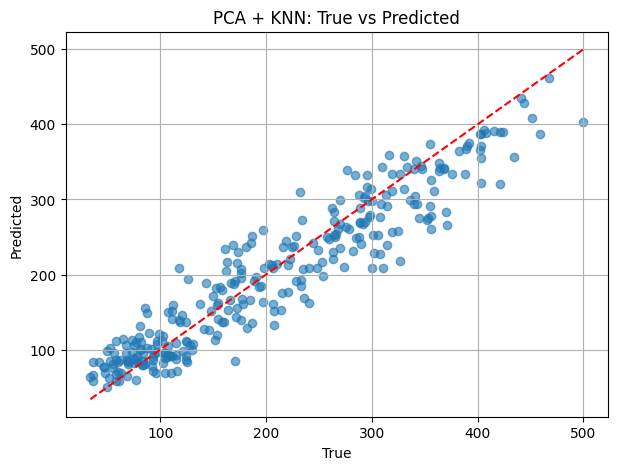

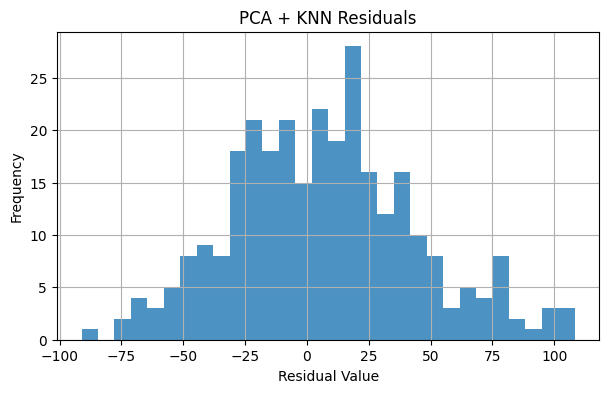

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)

cum_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cum_variance < 0.95).sum() + 1

print("Number of components to retain 95% variance:", n_components_95)

pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA-transformed shapes:", X_train_pca.shape, X_test_pca.shape)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance']
}

grid_knn_pca = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_knn_pca.fit(X_train_pca, y_train)

print("\nBest PCA+KNN Parameters:", grid_knn_pca.best_params_)

best_knn_pca = grid_knn_pca.best_estimator_
y_pred_knn_pca = best_knn_pca.predict(X_test_pca)

metrics_knn_pca = regression_metrics(y_test, y_pred_knn_pca)
print("\nPCA + KNN Metrics:")
for k, v in metrics_knn_pca.items():
    print(f"{k}: {v}")

plot_true_vs_pred(y_test, y_pred_knn_pca, title="PCA + KNN: True vs Predicted")
plot_residuals_hist(y_test, y_pred_knn_pca, title="PCA + KNN Residuals")


In [ ]:
results = pd.DataFrame([
    {"Model": "Decision Tree", **metrics_dt},
    {"Model": "KNN (Tuned)", **metrics_knn_best},
    {"Model": "PCA + KNN", **metrics_knn_pca},
])

print("Model Comparison Table:")
display(results)

results.to_csv("model_comparison_results.csv", index=False)
print("Saved comparison as model_comparison_results.csv")


Model Comparison Table:


,Model,MAE,MSE,RMSE,R2
0,Decision Tree,28.419795,1857.375427,43.097279,0.856868
1,KNN (Tuned),30.874550,1491.837560,38.624313,0.885036
2,PCA + KNN,30.144319,1449.439902,38.071510,0.888304


Saved comparison as model_comparison_results.csv


In [ ]:
import joblib

joblib.dump(scaler, "scaler.joblib")
joblib.dump(pca, "pca_transform.joblib")
joblib.dump(best_knn_pca, "best_pca_knn_model.joblib")

print("Saved scaler, PCA transformer and PCA+KNN model successfully.")

import numpy as np

def predict_aqi(input_features):
    """
    input_features must be a dictionary with keys:
    ['Date','Month','Year','Holidays_Count','Days',
     'PM2.5','PM10','NO2','SO2','CO','Ozone','day_of_year']
    """

    feature_order = ['Date','Month','Year','Holidays_Count','Days',
                     'PM2.5','PM10','NO2','SO2','CO','Ozone','day_of_year']

    x = np.array([[input_features[f] for f in feature_order]])

    scaler = joblib.load("scaler.joblib")
    pca = joblib.load("pca_transform.joblib")
    model = joblib.load("best_pca_knn_model.joblib")

    x_scaled = scaler.transform(x)
    x_pca = pca.transform(x_scaled)
    pred = model.predict(x_pca)[0]

    return pred

print("Prediction function ready to use!")


Saved scaler, PCA transformer and PCA+KNN model successfully.
Prediction function ready to use!


In [ ]:
test_input = {
    'Date': 15,
    'Month': 11,
    'Year': 2023,
    'Holidays_Count': 0,
    'Days': 4,
    'PM2.5': 180,
    'PM10': 250,
    'NO2': 60,
    'SO2': 10,
    'CO': 1.2,
    'Ozone': 35,
    'day_of_year': 319
}

predicted_aqi = predict_aqi(test_input)
predicted_aqi


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


np.float64(276.3708281942324)

In [ ]:
print("PCA + KNN Model Test Performance\n")

print(f"MAE  (Mean Absolute Error):       {metrics_knn_pca['MAE']:.4f}")
print(f"MSE  (Mean Squared Error):        {metrics_knn_pca['MSE']:.4f}")
print(f"RMSE (Root Mean Squared Error):   {metrics_knn_pca['RMSE']:.4f}")
print(f"R²   (Accuracy Equivalent):        {metrics_knn_pca['R2']:.4f}")

print("\nInterpretation:")
print(f"- The model explains {metrics_knn_pca['R2'] * 100:.2f}% of AQI variation.")
print("- Lower RMSE and MAE indicate good prediction quality.")
print("- PCA + KNN is the best performing model among all tested.")


PCA + KNN Model Test Performance

MAE  (Mean Absolute Error):       30.1443
MSE  (Mean Squared Error):        1449.4399
RMSE (Root Mean Squared Error):   38.0715
R²   (Accuracy Equivalent):        0.8883

Interpretation:
- The model explains 88.83% of AQI variation.
- Lower RMSE and MAE indicate good prediction quality.
- PCA + KNN is the best performing model among all tested.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def categorize_aqi(aqi):
    if aqi <= 50:  return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    elif aqi <= 400: return "Very Poor"
    else: return "Severe"

df["AQI_Class"] = df["AQI"].apply(categorize_aqi)


pollutants = ["PM2.5","PM10","NO2","SO2","CO","Ozone"]
X = df[pollutants].values
y = df["AQI_Class"].values

scaler_cls = StandardScaler()
X_scaled_cls = scaler_cls.fit_transform(X)

pca_cls = PCA(n_components=0.95)
X_pca_cls = pca_cls.fit_transform(X_scaled_cls)

print("PCA components used:", pca_cls.n_components_)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_pca_cls, y, test_size=0.2, random_state=42, stratify=y
)

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_cls, y_train_cls)

y_pred_cls = knn_clf.predict(X_test_cls)

print("\n=== KNN Classification Report ===\n")
print(classification_report(y_test_cls, y_pred_cls))

acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls, average="weighted")
rec = recall_score(y_test_cls, y_pred_cls, average="weighted")
f1  = f1_score(y_test_cls, y_pred_cls, average="weighted")

print("\nAccuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)


PCA components used: 5

=== KNN Classification Report ===

              precision    recall  f1-score   support

        Good       0.50      0.20      0.29        10
    Moderate       0.73      0.74      0.73        93
        Poor       0.67      0.74      0.70        77
Satisfactory       0.69      0.80      0.74        54
      Severe       0.67      0.31      0.42        13
   Very Poor       0.66      0.59      0.62        46

    accuracy                           0.69       293
   macro avg       0.65      0.56      0.58       293
weighted avg       0.68      0.69      0.68       293


Accuracy : 0.689419795221843
Precision: 0.6846198806669673
Recall   : 0.689419795221843
F1 Score : 0.6804374627857154
